In [1]:
import pandas as pd 
pd.set_option('display.max_columns', 30); pd.set_option('display.max_rows', 100)
from cmlreaders import get_data_index
import xarray as xarray
import matplotlib.pyplot as plt
from pylab import *
plt.rcParams['pdf.fonttype'] = 42; plt.rcParams['ps.fonttype'] = 42 # fix fonts for Illustrator
from general import *
from SWRmodule import *
from HFA_ripples_analysis import HFA_ripples_analysis
import pickle

/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/ptsa/data/timeseries.py:526: FutureWarning: xarray subclass TimeSeriesX should explicitly define __slots__
  class TimeSeriesX(TimeSeries):
/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
def convert_elec_2d(array_3d):
    
    array_3d_swapped = np.swapaxes(array_3d, 0, 1)
    return np.reshape(array_3d_swapped, (-1, array_3d_swapped.shape[-1]))

def load_data(dir, region_name):
    
    HFA = []
    ripples = []
    theta_phase = []
    word_correct_array = []
    clustered_array = []
    recalled_position_array = []
    list_num_key = []
    elec_names = []
    subj_names = []
    sess_names = []
    
    file_list = os.listdir(dir)
    for f in file_list:
        
        if region_name not in f:
            continue
        
        # Open the pickle file for reading
        with open(f'{catFR_dir}/{f}', 'rb') as pickle_file:
            loaded_data = pickle.load(pickle_file)    
            
            
        num_trials = loaded_data['HFA_pow'].shape[0]
        
        # For these arrays - HFA, theta phase, and ripples,
        # the original shape is num_trials x num_elec x num_timesteps
        # we swap the first two axes and then reshape to 2d
        # each num trials entries will then correspond the neural data from 
        # a given electrode
        HFA.append(convert_elec_2d(loaded_data['HFA_pow']))
        theta_phase.append(convert_elec_2d(loaded_data['theta_phase_array']))
        ripples.append(convert_elec_2d(loaded_data['ripple_array']))
        
        # list where number of elements equals num_elec
        # we want to vstack these elements so they align with the values above 
        # i.e. will be a 1d vector of size num_elec x num_trials 
        word_correct_array.extend(np.vstack(loaded_data['encoded_word_key_array']).reshape(-1))
        
        # these are already of the correct shape (1d vector of size num_elec x num_trials)
        # so just extend the list to accomadate them
        clustered_array.extend(loaded_data['semantic_clustering_key'])
        recalled_position_array.extend(loaded_data['recall_position_array'])
        list_num_key.extend(loaded_data['list_num_key'])
        
        # dimension number of electrodes, so need to expand out
        # each element num_trias times 
        elec_names.extend(np.repeat(loaded_data['elec_names'], num_trials))
        subj_names.extend(np.repeat(loaded_data['sub_names'], num_trials))
        sess_names.extend(np.repeat(loaded_data['sub_sess_names'], num_trials))
        
    HFA_np = np.vstack(HFA)
    theta_phase_np = np.vstack(theta_phase)
    ripples_np = np.vstack(ripples)
    word_correct_np = np.asarray(word_correct_array)
    clustered_np = np.asarray(clustered_array)
    recalled_np = np.asarray(recalled_position_array)
    elec_names_np = np.asarray(elec_names)
    subj_names_np = np.asarray(subj_names)
    sess_names_np = np.asarray(sess_names)   
            
            
        

In [ ]:
catFR_dir = '/scratch/efeghhi/catFR1/ENCODING'
region_name = 'HPC'


In [3]:
ca1 = ['"ca1"', 'left ca1', 'right ca1']
non_ca1 = ['"dg"', '"sub"', 'left ca2', 'left ca3', 'left dg', 'right dg', 'right sub', 'left sub']

In [5]:
word_correct_np_0_1 = np.where(word_correct_np>0, 1, 0)

In [6]:
def remove_lists_not_ll(list_num_key, list_length=12):
        
    list_num = 1 
    ll = 0 # position in list
    num_lists_wrong = 0
    mask_idxs_all = []
    
    # shape num_trials, where each element is the list
    # number that this trial corresponds to
    list_num_key_np_all = np.array(list_num_key)
    
    for i in range(list_num_key_np_all.shape[0]):
        
        # increment ll when on the same list
        if list_num_key_np_all[i] == list_num:
            ll += 1 
            
        # moving to another list
        else:
            # if list was not of list length, add it to the mask
            if ll != list_length:
                mask_idxs = [x for x in range(i-ll, i)]
                mask_idxs_all.append(mask_idxs)
                num_lists_wrong += 1
                
            # update list_num and ll
            list_num = list_num_key_np_all[i]
            ll = 1  
            
    return np.hstack(mask_idxs_all)

In [7]:
mask_idxs = remove_lists_not_ll(list_num_key)

In [8]:
analysis_one = {'HFA': HFA_np, 'theta_phase': theta_phase_np, 'ripples': ripples_np, 
                'clustered': clustered_np, 'word_correct': word_correct_np, 
                'recalled': recalled_np, 'elec_names': elec_names_np, 'subj': subj_names_np, 
                'sess': sess_names_np}
analysis_one_masked = {}

for key, val in analysis_one.items():
    analysis_one_masked[key] = np.delete(val, mask_idxs, axis=0)

In [9]:
analysis_one['HFA'].shape[0] - analysis_one_masked['HFA'].shape[0]

19

In [10]:
def create_semantic_clustered_array(recall_position_np, semantic_array_np, 
                                    clustered=['A','C'], unclustered=['D', 'Z']):
            
    '''
    :param list clustered: indicates what recalls count as clustered. There are four possible recalls:
        1) 'A': adjacent semantic
        2) 'C': remote semantic
        3) 'D': remote unclustered
        4) 'Z': dead end 
    The default is to use A and C as clustered, and D and Z as unclustered. 
    '''
    
    list_length = 12
    num_selected_trials = recall_position_np.shape[0]
    number_of_lists = int(num_selected_trials/list_length)
    semantic_clustered_array_np = np.zeros((number_of_lists, list_length))
    dead_ends = 0
    remote_semantic = 0
    adjacent_semantic = 0
    remote_nonsemantic = 0
    adjacent_nonsemantic = 0
    counter = 0
    
    for list_idx in range(0, num_selected_trials, list_length):
        
        # recall_position_np and semantic_array_np contain information 
        # about the word that was recalled and its clustering type, respectively
        # this information is repeated list_length times, so our for loop will 
        # increment by list length 
        recalled_idx = recall_position_np[list_idx] 
        cluster = semantic_array_np[list_idx]
        
        # init values to -1 so that non recalled items are -1 
        cluster_trial_np = np.ones(list_length)*-1
        
        for r, c in zip(recalled_idx, cluster):
            if r > 0 and r <= list_length:
                if c in clustered:
                    cluster_trial_np[r-1] = 1 # change to 1 for clustered recall
                elif c in unclustered:
                    cluster_trial_np[r-1] = 0 # change to 0 for unclustered but recalled
                if c=='A':
                    adjacent_semantic += 1
                if c=='C':
                    remote_semantic += 1
                if c=='D':
                    remote_nonsemantic += 1
                if c=='Z':
                    dead_ends += 1
                
        semantic_clustered_array_np[counter] = cluster_trial_np
        
        counter += 1
        
    semantic_clustered_array_np = np.ravel(semantic_clustered_array_np)
    
    return semantic_clustered_array_np

In [11]:
semantic_clustered_np = create_semantic_clustered_array(analysis_one_masked['recalled'], 
                                                        analysis_one_masked['clustered'])
analysis_one_masked['clustered_formatted'] = semantic_clustered_np
mask_idxs_2 = np.argwhere(semantic_clustered_np==-1)
for key, val in analysis_one_masked.items():
    analysis_one_masked[key] = np.delete(val, mask_idxs_2, axis=0)

In [12]:
ripple_start_time = 400
ripple_end_time = 1100
start_time = -700
sr_factor = 2

# ripple exists is a binary array, with a 1 if a ripple occurred in that specific electrode 
# between 400 and 1100 ms
ripple_start_time_sr = int((ripple_start_time - start_time) / sr_factor)
ripple_end_time_sr = int((ripple_end_time - start_time) / sr_factor)
ripple_exists = np.zeros(analysis_one_masked['ripples'].shape[0])
ripple_exists[np.argwhere(np.sum(analysis_one_masked['ripples'][:, ripple_start_time_sr:ripple_end_time_sr],axis=1) > 0)] = 1
analysis_one_masked['ripple_exists'] = ripple_exists


ca1_trial_idxs = []
for j, elec_name in enumerate(analysis_one_masked['elec_names']):
    if elec_name in ca1:
        ca1_trial_idxs.append(j)
ca1_trial_idxs = np.array(ca1_trial_idxs)
num_elec = analysis_one_masked['elec_names'].shape[0]
print(f'{ca1_trial_idxs.shape[0]} ca1 electrodes out of {num_elec} electrodes')

analysis_one_masked_ca1 = {}
for key, val in analysis_one_masked.items():
    analysis_one_masked_ca1[key] = val[ca1_trial_idxs]
    
    
non_ca1_trial_idxs = []
for j, elec_name in enumerate(analysis_one_masked['elec_names']):
    if elec_name in non_ca1:
        non_ca1_trial_idxs.append(j)
non_ca1_trial_idxs = np.array(non_ca1_trial_idxs)
num_elec = analysis_one_masked['elec_names'].shape[0]
print(f'{non_ca1_trial_idxs.shape[0]} non ca1 electrodes out of {num_elec} electrodes')

analysis_one_masked_non_ca1 = {}
for key, val in analysis_one_masked.items():
    analysis_one_masked_non_ca1[key] = val[non_ca1_trial_idxs]

35851 ca1 electrodes out of 94869 electrodes
26749 non ca1 electrodes out of 94869 electrodes


In [13]:
def SEM(vec, axis_num):
    return np.std(vec, axis=axis_num)/(vec.shape[0]**.5)

def plot_clustered_vs_not_clustered(freq_band, clustered, not_clustered, title_str):
    
    plt.errorbar(np.arange(150), np.mean(freq_band[clustered], axis=0), yerr=SEM(freq_band[clustered], 0),
                 label=f'C ({freq_band[clustered].shape[0]})')
    plt.errorbar(np.arange(150), np.mean(freq_band[not_clustered], axis=0), yerr=SEM(freq_band[not_clustered], 0),
                 label=f'NC ({freq_band[not_clustered].shape[0]})')
    plt.xlabel("Time (20 ms bins)")
    plt.ylabel("Normalized power")
    plt.title(title_str)
    plt.legend()
    plt.show()
 
def convert_clustered_to_idxs(clustered_array, ripple_exists, divide_by_ripples):
 
    clustered = []
    no_clustered = []
    for idx, i in enumerate(clustered_array):
        if i == 1:
            clustered.append(idx)
        if i == 0:
            no_clustered.append(idx)

                
    clustered = np.asarray(clustered)
    no_clustered = np.asarray(no_clustered)
    
    if divide_by_ripples:
        ripple_idxs = np.argwhere(ripple_exists==1)
        clustered_ripple = np.intersect1d(ripple_idxs, clustered)
        clustered_no_ripple = np.setdiff1d(clustered, clustered_ripple)
        no_clustered_ripple = np.intersect1d(ripple_idxs, no_clustered)
        no_clustered_no_ripple = np.setdiff1d(no_clustered, no_clustered_ripple)
        return clustered, no_clustered, clustered_ripple, clustered_no_ripple, no_clustered_ripple, no_clustered_no_ripple
        
    return clustered, no_clustered  

In [14]:
clustered, no_clustered, clustered_ripple, clustered_no_ripple, no_clustered_ripple, no_clustered_no_ripple = convert_clustered_to_idxs(analysis_one_masked['clustered_formatted'], 
                                                                                                                                        analysis_one_masked['ripple_exists'], True)


In [15]:
clustered_ca1, no_clustered_ca1, clustered_ripple_ca1, clustered_no_ripple_ca1, no_clustered_ripple_ca1, no_clustered_no_ripple_ca1 = convert_clustered_to_idxs(analysis_one_masked_ca1['clustered_formatted'], 
                                                                                                                                        analysis_one_masked_ca1['ripple_exists'], True)

In [16]:
clustered_non_ca1, no_clustered_non_ca1, clustered_ripple_non_ca1, clustered_no_ripple_non_ca1, no_clustered_ripple_non_ca1, no_clustered_no_ripple_non_ca1 = convert_clustered_to_idxs(analysis_one_masked_non_ca1['clustered_formatted'], 
                                                                                                                                        analysis_one_masked_non_ca1['ripple_exists'], True)

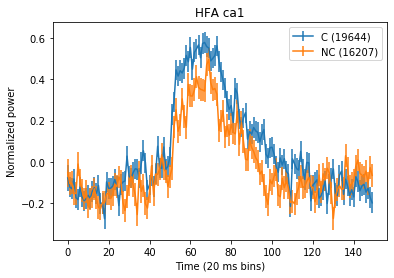

In [17]:
plot_clustered_vs_not_clustered(analysis_one_masked_ca1['HFA'], clustered_ca1, no_clustered_ca1, title_str='HFA ca1')

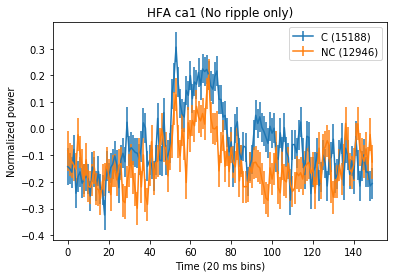

In [18]:
plot_clustered_vs_not_clustered(analysis_one_masked_ca1['HFA'], clustered_no_ripple_ca1, no_clustered_no_ripple_ca1,
                                title_str='HFA ca1 (No ripple only)')

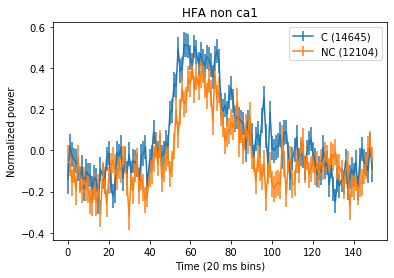

In [19]:
plot_clustered_vs_not_clustered(analysis_one_masked_non_ca1['HFA'], clustered_non_ca1, no_clustered_non_ca1, title_str='HFA non ca1')

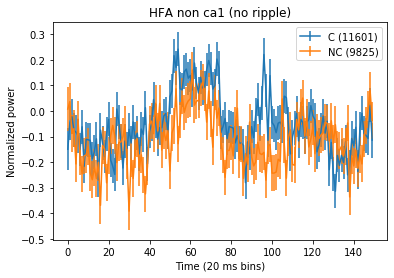

In [20]:
plot_clustered_vs_not_clustered(analysis_one_masked_non_ca1['HFA'], clustered_no_ripple_non_ca1, no_clustered_no_ripple_non_ca1, title_str='HFA non ca1 (no ripple)')

In [41]:
def plot_SCE_all_vs_no_ripple(analysis_dict, HFA_start, HFA_end, clustered, not_clustered, clustered_no_ripple, not_clustered_no_ripple, title_str):
    
    HFA_meaned = np.mean(analysis_dict['HFA'][:, HFA_start:HFA_end], axis=-1)
    print(HFA_meaned.shape)
    HFA_meaned_no_ripple_not_clust = HFA_meaned[not_clustered_no_ripple]
    HFA_meaned_no_ripple_clust = HFA_meaned[clustered_no_ripple]
    HFA_meaned_not_clust = HFA_meaned[not_clustered]
    HFA_meaned_clust = HFA_meaned[clustered]
    plt.errorbar(['C - NC (No ripple)', 'C - NC (All)'], [np.mean(HFA_meaned_no_ripple_clust)-np.mean(HFA_meaned_no_ripple_not_clust), np.mean(HFA_meaned_clust)- np.mean(HFA_meaned_not_clust)], 
             yerr=[SEM(HFA_meaned_no_ripple_clust, 0), SEM(HFA_meaned_no_ripple_not_clust,0)])
    plt.ylabel("Normalized power")
    plt.title(title_str)
    plt.show()


(35851,)


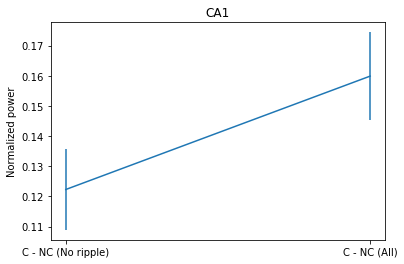

(26749,)


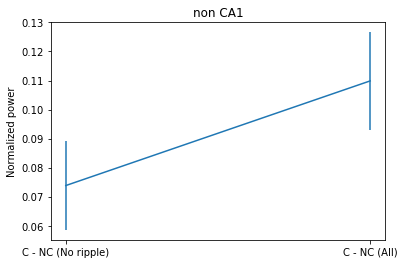

In [42]:
# only care about activity between 400-1100 ms post word onset for now
# ripple_start_time_sr and ripple_end_time_sr give us this range, but 
# with sampling rate of 500 Hz, for HFA we have a sampling rate of 50 Hz 
# so we need to divide by 10
HFA_start = int(ripple_start_time_sr / 10)
HFA_end = int(ripple_end_time_sr / 10)
plot_SCE_all_vs_no_ripple(analysis_one_masked_ca1, HFA_start, HFA_end, clustered_ca1, no_clustered_ca1, clustered_no_ripple_ca1, no_clustered_no_ripple_ca1, 'CA1')
plot_SCE_all_vs_no_ripple(analysis_one_masked_non_ca1, HFA_start, HFA_end, clustered_non_ca1, no_clustered_non_ca1, clustered_no_ripple_non_ca1, no_clustered_no_ripple_non_ca1, 'non CA1')

In [44]:
def create_lmm_pd(analysis_dict, HFA_meaned):
    
    lmm_pd = pd.DataFrame({'ripple_exists': analysis_dict['ripple_exists'], 
                            'HFA': HFA_meaned,
                            'clustered': analysis_dict['clustered_formatted'], 
                            'sess':analysis_dict['sess'], 
                            'subj':analysis_dict['subj']})
    return lmm_pd


In [48]:
import statsmodels.formula.api as smf
vc = {'sess':'0+sess'}
ripples_HFA_lmm = pd.DataFrame({'ripple_exists': analysis_one_masked_ca1['ripple_exists'], 
                            'HFA': HFA_meaned,
                            'clustered': analysis_one_masked_ca1['clustered_formatted'], 
                            'sess':analysis_one_masked_ca1['sess'], 
                            'subj':analysis_one_masked_ca1['subj']})


In [53]:
ripples_HFA_lmm['HFA'].shape

(35851,)

In [86]:
formula = 'clustered ~ ripple_exists'
re_formula = 'ripple_exists'
model = smf.mixedlm(formula, ripples_HFA_lmm, groups="subj", vc_formula=vc, 
                                        re_formula=f'{re_formula}')
results = model.fit()
results.summary()

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:1286: RuntimeWarning: invalid value encountered in sqrt
  bse_ = np.sqrt(np.diag(self.cov_params()))


<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
==================================================================
Model:               MixedLM    Dependent Variable:    clustered  
No. Observations:    35851      Method:                REML       
No. Groups:          101        Scale:                 0.2392     
Min. group size:     8          Likelihood:            -25396.8245
Max. group size:     6613       Converged:             Yes        
Mean group size:     355.0                                        
------------------------------------------------------------------
                         Coef. Std.Err.   z    P>|z| [0.025 0.975]
------------------------------------------------------------------
Intercept                0.486    0.011 44.140 0.000  0.464  0.507
ripple_exists            0.025    0.005  5.550 0.000  0.016  0.034
subj Var                 0.008    0.004                           
subj x ripple_exists Cov 0.000    0.002                           
ripple_exists Var        0.001                                    
sess Var                 0.003    0.001                           
==================================================================

"""

In [50]:
formula = 'clustered ~ HFA'
re_formula = 'HFA'
model = smf.mixedlm(formula, ripples_HFA_lmm, groups="subj", vc_formula=vc, 
                                        re_formula=f'{re_formula}')
results = model.fit()
results.summary()

/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: clustered  
No. Observations: 35851   Method:             REML       
No. Groups:       101     Scale:              0.2376     
Min. group size:  8       Likelihood:         -25457.1628
Max. group size:  6613    Converged:          No         
Mean group size:  355.0                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.481    0.025 19.593 0.000  0.433  0.529
HFA             0.009    0.002  4.212 0.000  0.005  0.013
subj Var        0.037                                    
subj x HFA Cov  0.001    0.002                           
HFA Var         0.000    0.000                           
sess Var        0.033                                    
=========================================================

"""

In [88]:
formula = 'clustered ~ HFA'
re_formula = 'HFA'
model = smf.mixedlm(formula, ripples_HFA_lmm, groups="subj", 
                                        re_formula=f'{re_formula}')
results = model.fit()
results.summary()

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2094: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


<class 'statsmodels.iolib.summary2.Summary'>
"""
          Mixed Linear Model Regression Results
=========================================================
Model:            MixedLM Dependent Variable: clustered  
No. Observations: 35851   Method:             REML       
No. Groups:       101     Scale:              0.2403     
Min. group size:  8       Likelihood:         -25436.8660
Max. group size:  6613    Converged:          Yes        
Mean group size:  355.0                                  
---------------------------------------------------------
                Coef. Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------
Intercept       0.488    0.011 44.598 0.000  0.467  0.509
HFA             0.008    0.002  3.141 0.002  0.003  0.012
subj Var        0.010    0.004                           
subj x HFA Cov  0.000    0.001                           
HFA Var         0.000    0.000                           
=========================================================

"""

In [49]:
formula = 'clustered ~ HFA + HFA:ripple_exists'
re_formula = 'HFA + HFA:ripple_exists'
model = smf.mixedlm(formula, ripples_HFA_lmm, groups="subj", 
                                        re_formula=f'{re_formula}')
results = model.fit()
results.summary()

/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/home1/efeghhi/.conda/envs/env3/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

<class 'statsmodels.iolib.summary2.Summary'>
"""
                 Mixed Linear Model Regression Results
=======================================================================
Model:                  MixedLM     Dependent Variable:     clustered  
No. Observations:       35851       Method:                 REML       
No. Groups:             101         Scale:                  0.2402     
Min. group size:        8           Likelihood:             -25443.7680
Max. group size:        6613        Converged:              No         
Mean group size:        355.0                                          
-----------------------------------------------------------------------
                             Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------------------
Intercept                     0.488    0.011 45.045 0.000  0.467  0.510
HFA                           0.007    0.003  2.466 0.014  0.001  0.012
HFA:ripple_exists            -0.002    0.004 -0.358 0.720 -0.010  0.007
subj Var                      0.009    0.004                           
subj x HFA Cov                0.001    0.001                           
HFA Var                       0.000    0.000                           
subj x HFA:ripple_exists Cov  0.000    0.001                           
HFA x HFA:ripple_exists Cov   0.000    0.000                           
HFA:ripple_exists Var         0.000    0.000                           
=======================================================================

"""

In [95]:
# Previous analysis repeated the trials per session based on 
# the number of electrodes. In this analysis, we won't do this.
# Instead, we'll only take trials with ca1 electrodes, and create
# a ripple exists array based on if there is a ripple in any of the
# ca1 electrodes.
ca1_only = {'ripple': [], 'HFA': [], 'clust': [], 'correct': [], 'position': [], 
            'list_num': [], 'subj': [], 'sess': []}
catFR_dir = '/scratch/efeghhi/catFR1/ENCODING'
file_list = os.listdir(catFR_dir)


ripple_start_time = 400
ripple_end_time = 1100
start_time = -700
sr_factor = 2

# ripple exists is a binary array, with a 1 if a ripple occurred in that specific electrode 
# between 400 and 1100 ms
ripple_start_time_sr = int((ripple_start_time - start_time) / sr_factor)
ripple_end_time_sr = int((ripple_end_time - start_time) / sr_factor)

for f in file_list:
    
    # Open the pickle file for reading
    with open(f'{catFR_dir}/{f}', 'rb') as pickle_file:
        loaded_data = pickle.load(pickle_file)    
        
    ca1_elecs = []
    elec_names = loaded_data['elec_names']
    for i, elec in enumerate(elec_names):
        if elec in ca1:
            ca1_elecs.append(i)
            
    if len(ca1_elecs) == 0:
        continue 
    
    ripples_3d = loaded_data['ripple_array']
    HFA_3d = loaded_data['HFA_pow']
    num_trials = ripples_3d.shape[0]
    rippled_3d_channels_first = np.swapaxes(ripples_3d, 0, 1)
    HFA_3d_channels_first = np.swapaxes(HFA_3d, 0, 1)
    ripples_3d_ca1 = rippled_3d_channels_first[ca1_elecs]
    HFA_3d_ca1 = HFA_3d_channels_first[ca1_elecs]
    
    # shape num trials, zero if there is no ripple in any ca1 electrode,
    # 1 if there is a ripple (in the specified time range) for any ca1 
    # electrode
    ripple_exists = np.zeros(num_trials)
    
    # sum across channels and relevant timesteps to see if a ripple exists
    trials_with_ripples = np.argwhere(np.sum(ripples_3d_ca1[:, :, ripple_start_time_sr:ripple_end_time_sr], axis=(0,2)) > 0)
    ripple_exists[trials_with_ripples] = 1
    ca1_only['ripple'].extend(ripple_exists)
    ca1_only['HFA'].extend(np.mean(HFA_3d_ca1[:, :, HFA_start:HFA_end], axis=(0,2)))
    
    ca1_only['correct'].extend(loaded_data['encoded_word_key_array'][0])
    ca1_only['clust'].extend(loaded_data['semantic_clustering_key'][:num_trials])
    ca1_only['position'].extend(loaded_data['recall_position_array'][:num_trials])
    ca1_only['list_num'].extend(loaded_data['list_num_key'][:num_trials])
    
    ca1_only['subj'].extend(np.repeat(loaded_data['sub_names'][0], num_trials))
    ca1_only['sess'].extend(np.repeat(loaded_data['sub_sess_names'][0], num_trials))


In [96]:
for key, val in ca1_only.items():
    ca1_only[key] = np.array(val)


In [97]:
mask_idxs = remove_lists_not_ll(ca1_only['list_num'])
print(mask_idxs)

[16944 16945 16946]


In [98]:
for key, val in ca1_only.items():
    print(key)
    print(val.shape)
    ca1_only[key] = np.delete(val, mask_idxs, axis=0)

ripple
(38439,)
HFA
(38439,)
clust
(38439,)
correct
(38439,)
position
(38439,)
list_num
(38439,)
subj
(38439,)
sess
(38439,)


In [99]:
semantic_clustered_np = create_semantic_clustered_array(ca1_only['position'], 
                                                        ca1_only['clust'])
ca1_only['clustered_formatted'] = semantic_clustered_np
mask_idxs_2 = np.argwhere(semantic_clustered_np==-1)
for key, val in ca1_only.items():
    ca1_only[key] = np.delete(val, mask_idxs_2, axis=0)

In [100]:
import statsmodels.formula.api as smf
vc = {'sess':'0+sess'}
ca1_only_pd = pd.DataFrame(ca1_only)

In [101]:
np.unique(ca1_only_pd['ripple'])

array([0., 1.])

In [102]:
formula = 'clustered_formatted ~ ripple + HFA'
re_formula = 'ripple + HFA'
model = smf.mixedlm(formula, ca1_only_pd, groups="subj", 
                                        re_formula=f'{re_formula}')
results = model.fit()
results.summary()

/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  ConvergenceWarning)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2059: ConvergenceWarning: Retrying MixedLM optimization with cg
  ConvergenceWarning)
/home1/efeghhi/.conda/envs/env1/lib/python3.7/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Chec

<class 'statsmodels.iolib.summary2.Summary'>
"""
              Mixed Linear Model Regression Results
=================================================================
Model:            MixedLM Dependent Variable: clustered_formatted
No. Observations: 11022   Method:             REML               
No. Groups:       101     Scale:              0.2432             
Min. group size:  4       Likelihood:         -7958.7064         
Max. group size:  753     Converged:          No                 
Mean group size:  109.1                                          
------------------------------------------------------------------
                   Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
------------------------------------------------------------------
Intercept           0.505     0.007  68.408  0.000   0.490   0.519
ripple              0.005     0.013   0.342  0.732  -0.021   0.030
HFA                 0.005     0.008   0.659  0.510  -0.011   0.022
subj Var            0.001     0.001                               
subj x ripple Cov   0.001     0.001                               
ripple Var          0.002     0.006                               
subj x HFA Cov     -0.000     0.001                               
ripple x HFA Cov   -0.000                                         
HFA Var             0.005                                         
=================================================================

"""

In [ ]:
pd.read_csv()